In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mlxtend 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<h2>Problem Description</h2>
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Data: Memorial Sloan Kettering Cancer Center (MSKCC)

Download training_variants.zip and training_text.zip from Kaggle.

<h3>Context:</h3>
Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

<h3>Problem statement :</h3>
Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

# from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

<h2>Dataset Overview</h2>


*   Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
*   We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that human experts/pathologists use to classify the genetic mutations.

*   Both these data files are have a common column called ID Data file's information:
1.   training_variants (ID , Gene, Variations, Class)
2.   training_text (ID, Text)








# Exploratory Data Analysis

In [ ]:
dataset1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Personalized Cancer Diagnosis/training_variants")
dataset1.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training/training_variants is a comma separated file containing the description of the genetic mutations used for training.
Fields are

1. ID : the id of the row used to link the mutation to the clinical evidence
2. Gene : the gene where this genetic mutation is located
3. Variation : the aminoacid change for this mutations
4. Class : 1-9 the class this genetic mutation has been classified on

In [ ]:
print("Number of Datapoints: ", dataset1.shape[0])
print("Number of Features: ", dataset1.shape[1])
print("Features: ", dataset1.columns.values)

Number of Datapoints:  3321
Number of Features:  4
Features:  ['ID' 'Gene' 'Variation' 'Class']


In [ ]:
dataset2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Personalized Cancer Diagnosis/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
dataset2.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [ ]:
print("Number of Datapoints: ", dataset2.shape[0])
print("Number of Features: ", dataset2.shape[1])
print("Features: ", dataset2.columns.values)

Number of Datapoints:  3321
Number of Features:  2
Features:  ['ID' 'TEXT']


<h2> Preprocessing of text </h2>

In [ ]:
# loading stop words from nltk library
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{'before', 'hasn', 'ma', 'is', 'at', 't', "don't", 'most', 'any', "won't", 'an', 'further', 'his', 'because', 'by', 'it', 'for', 'here', 'up', 'itself', 'them', 'being', 'herself', 'same', 'now', 'mightn', "isn't", 'me', "didn't", 'i', 'have', 're', "you'd", 'themselves', 'theirs', 'ain', 'haven', "it's", 'needn', "you'll", 'aren', 'those', 'too', 'himself', 'few', 'while', 'whom', "haven't", 'below', 'ours', 'myself', "wasn't", 'was', 'such', 'yourself', 'from', 'other', 'hadn', 'had', 'on', 'do', 'y', 'not', 'with', 'over', 'won', 'which', 'than', 'does', "shan't", 's', 'these', 'about', 'how', 'just', "that'll", 'there', 'what', 'own', 'she', 'as', 'don', 'yours', 'when', 'doing', 'or', 'll', 'am', 'we', "should've", "weren't", 'this', 'yourselves', 'isn', 'you', "aren't", 'in', 'were', 'd', 'and', "you've", 'where', "hasn't", 'between', 'he', 've', 'very', 'the', 'her', 'wasn', 'be', 'mustn', 'him', 'until', 'its', 'why', 'shouldn', 'all', "you're", "hadn't", 'your', 'against', 'wh

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# reference: https://gist.github.com/ranasingh-gkp/1a7bd69564e0636b9e258e7940c146c7

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        dataset2[column][index] = string

In [ ]:
# reference: https://gist.github.com/ranasingh-gkp/1a7bd69564e0636b9e258e7940c146c7
#text processing stage.

start_time = time.clock()
for index, row in dataset2.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 52.973856999999995 seconds


In [ ]:
#merging both gene_variations and text data based on ID
result = pd.merge(dataset1,dataset2,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [ ]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [ ]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


<h3>Test, Train and Cross Validation Split</h3>

<h4>Splitting data into train, test and cross validation (64:20:16)</h4>

In [ ]:
y = result['Class'].values
result['Gene'] = result.Gene.str.replace('\s+','_')
result['Variation'] = result.Variation.str.replace('\s+','_')

In [ ]:
# split the data into test and train by maintaining same distribution of output varaible 'y' [stratify=y]
X_train, X_test, y_train, y_test = train_test_split(result, y, test_size=0.2, stratify=y)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

<p> We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set  </p>

In [ ]:
print("Number of datapoints in Train Dataset:", X_train.shape[0])
print("Number of datapoints in CV Dataset:", X_cv.shape[0])
print("Number of datapoints in Test Dataset:", X_test.shape[0])

Number of datapoints in Train Dataset: 2124
Number of datapoints in CV Dataset: 532
Number of datapoints in Test Dataset: 665


<h4>Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

In [ ]:
train_data_distribution = X_train['Class'].value_counts().sort_index()
cv_data_distribution = X_cv['Class'].value_counts().sort_index()
test_data_distribution = X_test['Class'].value_counts().sort_index()

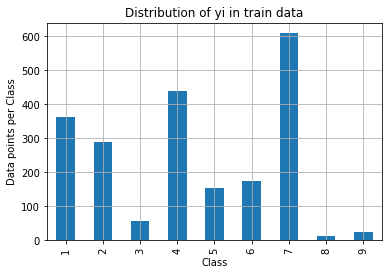

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


In [ ]:
my_colors = 'rgbkymc'
train_data_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_data_distribution.values)
for i in sorted_yi:
  print('Number of data points in class', i+1, ':',train_data_distribution.values[i], '(', np.round((train_data_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

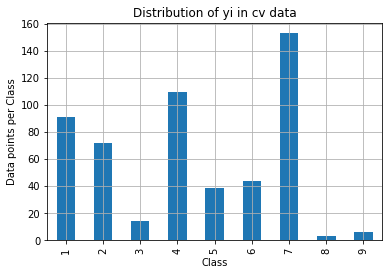

Number of data points in class 7 : 153 ( 7.203 %)
Number of data points in class 4 : 110 ( 5.179 %)
Number of data points in class 1 : 91 ( 4.284 %)
Number of data points in class 2 : 72 ( 3.39 %)
Number of data points in class 6 : 44 ( 2.072 %)
Number of data points in class 5 : 39 ( 1.836 %)
Number of data points in class 3 : 14 ( 0.659 %)
Number of data points in class 9 : 6 ( 0.282 %)
Number of data points in class 8 : 3 ( 0.141 %)


In [ ]:
my_colors = 'rgbkymc'
cv_data_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_data_distribution.values)
for i in sorted_yi:
  print('Number of data points in class', i+1, ':',cv_data_distribution.values[i], '(', np.round((cv_data_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

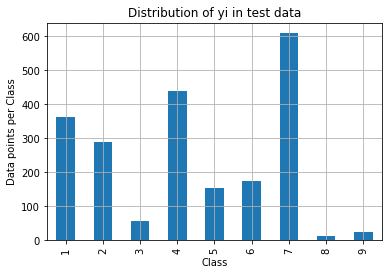

Number of data points in class 7 : 191 ( 8.992 %)
Number of data points in class 4 : 137 ( 6.45 %)
Number of data points in class 1 : 114 ( 5.367 %)
Number of data points in class 2 : 91 ( 4.284 %)
Number of data points in class 6 : 55 ( 2.589 %)
Number of data points in class 5 : 48 ( 2.26 %)
Number of data points in class 3 : 18 ( 0.847 %)
Number of data points in class 9 : 7 ( 0.33 %)
Number of data points in class 8 : 4 ( 0.188 %)


In [ ]:
my_colors = 'rgbkymc'
train_data_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_data_distribution.values)
for i in sorted_yi:
  print('Number of data points in class', i+1, ':',test_data_distribution.values[i], '(', np.round((test_data_distribution.values[i]/X_train.shape[0]*100), 3), '%)')

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sb.heatmap(C, annot=True, cmap="tab20", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sb.heatmap(B, annot=True, cmap="tab20", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sb.heatmap(A, annot=True, cmap="tab20", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.5775220142508406
Log loss on Cross Validation Data using Random Model 2.51125746775473
-------------------- Confusion matrix --------------------


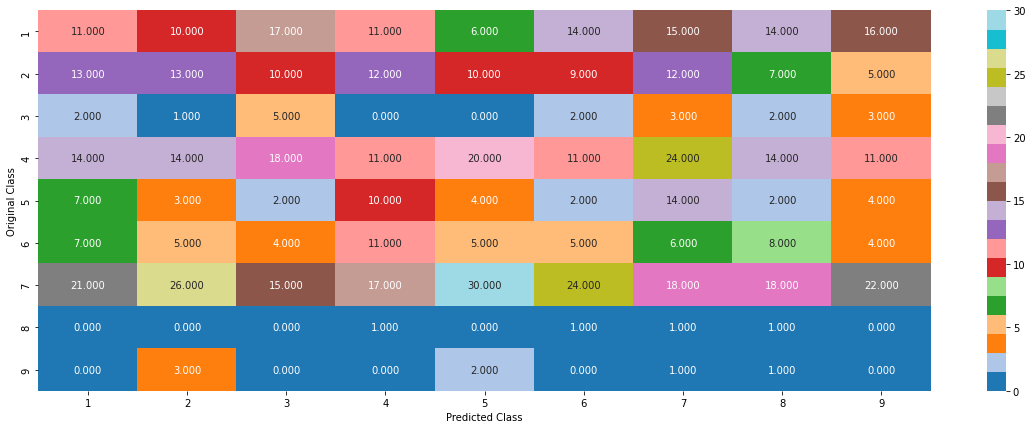

-------------------- Precision matrix (Columm Sum=1) --------------------


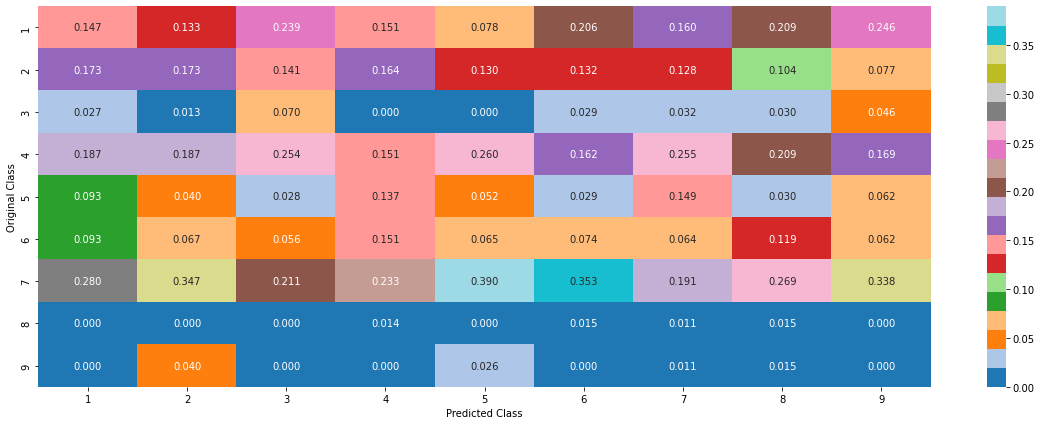

-------------------- Recall matrix (Row sum=1) --------------------


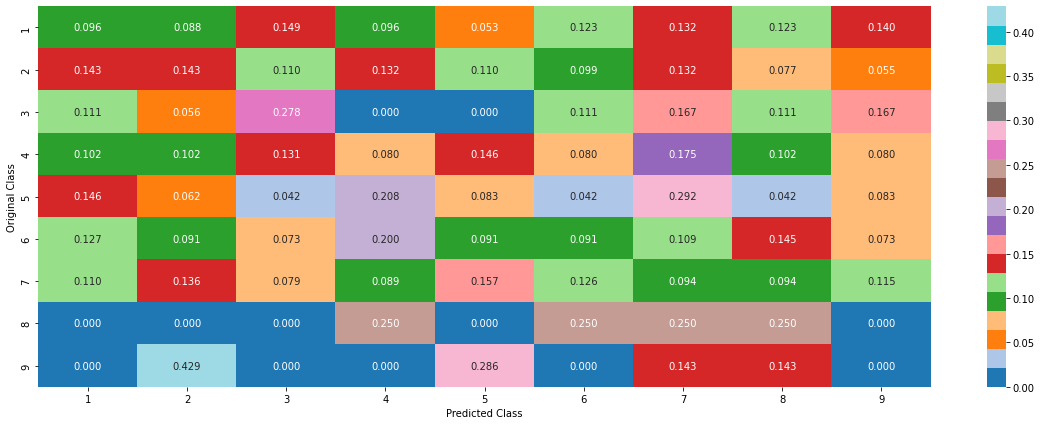

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = len(X_test) #665
cv_data_len = len(X_cv) #532

# we create a output array that has exactly same size as the CV data
cv_predicted = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
  random_no = np.random.rand(1,9)
  cv_predicted[i] = ((random_no/sum(sum(random_no)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted, eps=1e-15))

# we create a output array that has exactly same size as the test data
test_predicted = np.zeros((test_data_len,9))
for i in range(test_data_len):
  random_no = np.random.rand(1,9)
  test_predicted[i] = ((random_no/sum(sum(random_no)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_test,test_predicted, eps=1e-15))

predicted_y = np.argmax(test_predicted,axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [ ]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = X_train[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = X_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

when we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

<h2> Univariate Analysis in Gene Feature</h2>

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [ ]:
unique_genes = X_train['Gene'].value_counts()
print("Number of uniues Genes: ",unique_genes.shape[0])
unique_genes.head(30)

Number of uniues Genes:  234


BRCA1     163
TP53      105
EGFR      103
PTEN       89
BRCA2      80
BRAF       61
KIT        57
ERBB2      42
ALK        40
PIK3CA     37
PDGFRA     36
VHL        32
TSC2       31
FLT3       31
FGFR2      29
KRAS       29
RET        28
CDKN2A     27
MET        27
MTOR       27
JAK2       24
MLH1       23
MAP2K1     22
NOTCH1     22
SMAD4      22
ABL1       19
AKT1       19
FGFR3      19
SMAD3      18
HRAS       17
Name: Gene, dtype: int64

In [ ]:
print("Ans: There are {} different categories of genes in the train data, and they are distibuted as follows".format(unique_genes.shape[0]))

Ans: There are 234 different categories of genes in the train data, and they are distibuted as follows


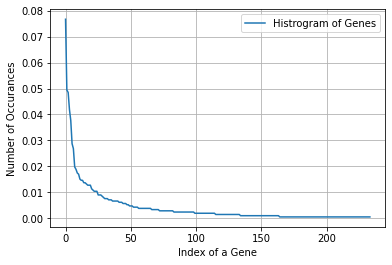

In [ ]:
v = unique_genes.values
s = sum(v)
h = v/s
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

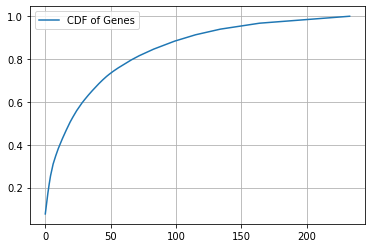

In [ ]:
c = np.cumsum(h)
plt.plot(c, label="CDF of Genes")
plt.legend()
plt.grid()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests. </p>

In [ ]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1

# train gene feature
train_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_train))
# cv gene feature
cv_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_cv))
# test gene feature
test_gene_responsecoding = np.array(get_gv_feature(alpha, 'Gene', X_test))

In [ ]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_responsecoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [ ]:
# one-hot encoding of Gene feature.
one_hot_encoder = CountVectorizer()
train_gene_onehotencoding = one_hot_encoder.fit_transform(X_train['Gene'])
cv_gene_onehotencoding = one_hot_encoder.transform(X_cv['Gene'])
test_gene_onehotencoding = one_hot_encoder.transform(X_test['Gene'])

In [ ]:
X_train['Gene'].head(20)

1720    KNSTRN
2320      JAK2
73       RAD50
842       ABL1
1361      AKT1
326       ROS1
1329      MLH1
3079    NOTCH1
742      ERBB2
1606       VHL
2765      BRAF
2834     BRCA2
42      DICER1
1399     FGFR3
1368      AKT2
2478     BRCA1
3184    TCF7L2
2375    PTPN11
1573       ALK
359      EP300
Name: Gene, dtype: object

In [ ]:
one_hot_encoder.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid5b',
 'asxl1',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'il7r',
 'inp

In [ ]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_onehotencoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 233)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.1874221615420122
For values of alpha =  0.0001 The log loss is: 1.1788235054074785
For values of alpha =  0.001 The log loss is: 1.243697199934124
For values of alpha =  0.01 The log loss is: 1.360271213193447
For values of alpha =  0.1 The log loss is: 1.461264039953507
For values of alpha =  1 The log loss is: 1.5034132561720004


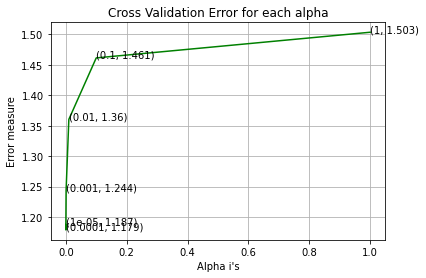

For values of best alpha =  0.0001 The train log loss is: 0.9834831211349071
For values of best alpha =  0.0001 The cross validation log loss is: 1.1788235054074785
For values of best alpha =  0.0001 The test log loss is: 1.2200720709884303


In [ ]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_onehotencoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_onehotencoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [ ]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage=X_cv[X_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  234  genes in train dataset?
Ans
1. In test data 648 out of 665 : 97.44360902255639
2. In cross validation data 515 out of  532 : 96.80451127819549


<h2>Univariate Analysis on Variation Feature</h2>

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [ ]:
unique_variations = X_train['Variation'].value_counts()
print("Number of uniues Genes: ",unique_variations.shape[0])
unique_variations.head(30)

Number of uniues Genes:  1942


Truncating_Mutations    55
Amplification           47
Deletion                45
Fusions                 18
Overexpression           6
G12V                     3
E17K                     3
Y64A                     2
A146T                    2
G12D                     2
V321M                    2
T73I                     2
Q61H                     2
T167A                    2
K117N                    2
G12C                     2
Q61R                     2
TMPRSS2-ETV1_Fusion      2
P34R                     2
C443Y                    1
Q477E                    1
S1498N                   1
CHTOP-NTRK1_Fusion       1
L344R                    1
V804M                    1
P86H                     1
P449_L455del             1
E1735K                   1
T123A                    1
H2074N                   1
Name: Variation, dtype: int64

In [ ]:
print("Ans: There are {} different categories of variations in the train data, and they are distibuted as follows".format(unique_variations.shape[0]))

Ans: There are 1942 different categories of variations in the train data, and they are distibuted as follows


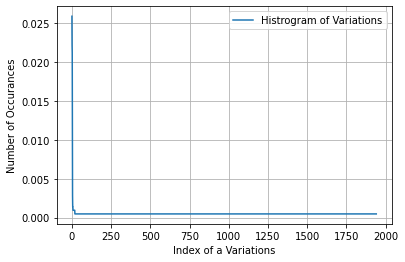

In [ ]:
v = unique_variations.values
s = sum(v)
h = v/s
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variations')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

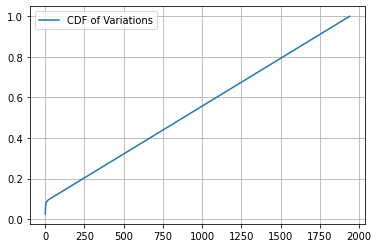

In [ ]:
c = np.cumsum(h)
plt.plot(c, label="CDF of Variations")
plt.legend()
plt.grid()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>There are two ways we can featurize this variable
<ol><li>One hot Encoding</li><li>Response coding</li></ol></p>
<p> We will be using both these methods to featurize the Variation Feature </p>

In [ ]:
#response-coding of the Variation feature
# alpha is used for laplace smoothing
alpha = 1

# train variation feature
train_variation_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_train))
# cv gene feature
cv_variation_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_cv))
# test gene feature
test_variation_responsecoding = np.array(get_gv_feature(alpha, 'Variation', X_test))

In [ ]:
print("train_data_responseCoding is converted feature using respone coding method. The shape of Variation feature:", train_variation_responsecoding.shape)

train_data_responseCoding is converted feature using respone coding method. The shape of Variation feature: (2124, 9)


In [ ]:
# one-hot encoding of Variation feature.
one_hot_encoder = CountVectorizer()
train_variation_onehotencoding = one_hot_encoder.fit_transform(X_train['Variation'])
cv_variation_onehotencoding = one_hot_encoder.transform(X_cv['Variation'])
test_variation_onehotencoding = one_hot_encoder.transform(X_test['Variation'])

In [ ]:
X_train['Variation'].head(20)

1720                    A40E
2320                   D544H
73                    L1273F
842                    E355A
1361                   D325A
326       KDELR2-ROS1_Fusion
1329                   L582F
3079                  L1678P
742                    H878Y
1606                   Y112H
2765                   K499E
2834                  K2950N
42                    E1705K
1399                   N540S
1368                    D32H
2478                  F1734S
3184    Truncating_Mutations
2375                    Q79R
1573                  I1170S
359                 Deletion
Name: Variation, dtype: object

In [ ]:
one_hot_encoder.get_feature_names()

['1_fusion',
 '2010_2471trunc',
 '385_418del',
 '51',
 '534_536del',
 '550_592del',
 '560_561inser',
 '963_d1010splice',
 '981_1028splice',
 '_deletion',
 '_fusion',
 'a1020v',
 'a1022e',
 'a1065t',
 'a1066v',
 'a111p',
 'a1131t',
 'a113_splice',
 'a1170v',
 'a120s',
 'a121e',
 'a122',
 'a1234t',
 'a126g',
 'a126s',
 'a126v',
 'a134d',
 'a1374v',
 'a1459p',
 'a146t',
 'a146v',
 'a151t',
 'a161t',
 'a1669s',
 'a1685s',
 'a1701p',
 'a1708e',
 'a1708v',
 'a1752v',
 'a1789s',
 'a1789t',
 'a1823t',
 'a1843p',
 'a1843t',
 'a197t',
 'a19v',
 'a205t',
 'a211d',
 'a2351g',
 'a2425t',
 'a2643g',
 'a298t',
 'a339v',
 'a349p',
 'a36p',
 'a389t',
 'a391e',
 'a39p',
 'a40e',
 'a41p',
 'a41t',
 'a500t',
 'a530v',
 'a532h',
 'a546d',
 'a598t',
 'a598v',
 'a59g',
 'a59t',
 'a60v',
 'a614d',
 'a617t',
 'a627t',
 'a633t',
 'a633v',
 'a636p',
 'a648t',
 'a677g',
 'a717g',
 'a727v',
 'a728v',
 'a72s',
 'a72v',
 'a750_e758del',
 'a750_e758delinsp',
 'a750p',
 'a75p',
 'a767_v769del',
 'a767_v769dup',
 'a77p

For values of alpha =  1e-05 The log loss is: 1.6876203588743857
For values of alpha =  0.0001 The log loss is: 1.6817109522207838
For values of alpha =  0.001 The log loss is: 1.6844953395023081
For values of alpha =  0.01 The log loss is: 1.7005847912514327
For values of alpha =  0.1 The log loss is: 1.7099850921626245
For values of alpha =  1 The log loss is: 1.7113023903572262


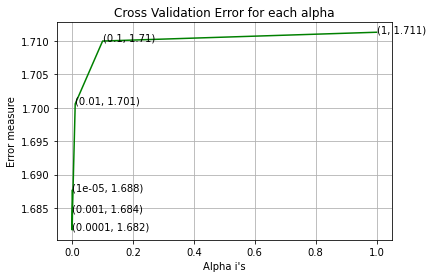

For values of best alpha =  0.0001 The train log loss is: 0.6585970107945873
For values of best alpha =  0.0001 The cross validation log loss is: 1.6817109522207838
For values of best alpha =  0.0001 The test log loss is: 1.6960903081481251


In [ ]:
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_onehotencoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_onehotencoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_onehotencoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [ ]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_variations.shape[0], " variations in train dataset?")

test_coverage=X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage=X_cv[X_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',X_cv.shape[0],":" ,(cv_coverage/X_cv.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  1942  variations in train dataset?
Ans
1. In test data 68 out of 665 : 10.225563909774436
2. In cross validation data 69 out of  532 : 12.969924812030076


<h3>Univariate Analysis on Text Feature</h3>

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [ ]:
# cls_text is a data frame
# for every row in data fram consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [ ]:
# # import math
# # #https://stackoverflow.com/a/1602964
# import math
# def get_text_responsecoding(df):
#     text_feature_responseCoding = np.zeros((df.shape[0],9))
#     for i in range(0,9):
#         row_index = 0
#         for index, row in df.iterrows():
#             sum_prob = 0
#             for word in row['TEXT'].split():
#                 sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
#             text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
#             row_index += 1
#     return text_feature_responseCoding

import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [ ]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52662


In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [ ]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(X_cv)

In [ ]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [ ]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(X_cv['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5106, 4: 3520, 5: 2786, 6: 2503, 9: 2133, 7: 2041, 8: 1966, 10: 1517, 12: 1365, 11: 1005, 13: 901, 16: 883, 15: 879, 14: 773, 18: 659, 20: 621, 19: 575, 17: 563, 24: 534, 22: 529, 21: 528, 41: 472, 28: 416, 27: 405, 25: 376, 23: 359, 30: 356, 29: 330, 26: 302, 31: 292, 32: 287, 36: 260, 35: 252, 33: 241, 48: 225, 42: 219, 34: 218, 40: 207, 38: 204, 37: 197, 47: 195, 44: 189, 39: 179, 45: 177, 43: 170, 56: 168, 50: 160, 49: 156, 46: 156, 52: 150, 63: 147, 51: 147, 57: 146, 58: 135, 60: 131, 54: 126, 53: 125, 66: 119, 64: 116, 55: 114, 61: 112, 59: 108, 65: 107, 72: 106, 62: 101, 70: 99, 67: 93, 82: 91, 68: 90, 94: 87, 73: 86, 71: 85, 69: 85, 78: 82, 83: 79, 84: 77, 92: 76, 80: 75, 93: 74, 91: 74, 76: 74, 74: 74, 75: 73, 85: 72, 81: 71, 86: 70, 77: 69, 88: 68, 97: 64, 90: 64, 79: 64, 100: 61, 111: 59, 112: 57, 87: 57, 98: 56, 114: 55, 108: 55, 96: 55, 89: 55, 106: 53, 105: 53, 95: 51, 110: 50, 99: 50, 117: 49, 107: 49, 141: 48, 123: 48, 104: 48, 103: 46, 148: 45, 119: 45, 118

For values of alpha =  1e-05 The log loss is: 1.3249768452411406
For values of alpha =  0.0001 The log loss is: 1.213151848891963
For values of alpha =  0.001 The log loss is: 1.1923050790491587
For values of alpha =  0.01 The log loss is: 1.278458510365237
For values of alpha =  0.1 The log loss is: 1.530838860259103
For values of alpha =  1 The log loss is: 1.6837249090007487


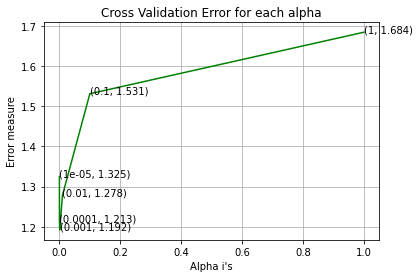

For values of best alpha =  0.001 The train log loss is: 0.6388253308572261
For values of best alpha =  0.001 The cross validation log loss is: 1.1923050790491587
For values of best alpha =  0.001 The test log loss is: 1.239912792307007


In [ ]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [ ]:
def get_intersec_text(df):
    
    # df = df['TEXT'].fillna(' ')
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(X_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.744 % of word of test data appeared in train data
97.891 % of word of Cross Validation appeared in train data


<h1>Machine Learning Models</h1>

In [ ]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log-Loss: ",log_loss(test_y,sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [ ]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_onehotencoding,train_variation_onehotencoding))
test_gene_var_onehotCoding = hstack((test_gene_onehotencoding,test_variation_onehotencoding))
cv_gene_var_onehotCoding = hstack((cv_gene_onehotencoding,cv_variation_onehotencoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(X_cv['Class']))

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54869)
(number of data points * number of features) in test data =  (665, 54869)
(number of data points * number of features) in cross validation data = (532, 54869)


In [ ]:
train_gene_var_responseCoding = np.hstack((train_gene_responsecoding, train_variation_responsecoding))
test_gene_var_responseCoding = np.hstack((test_gene_responsecoding,test_variation_responsecoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_responsecoding,cv_variation_responsecoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


<h2>Base Line Model</h2>



## Naive Bayes



<h4>1. Hyper parameter tuning</h4>

In [ ]:
# find more about Multinomial Naive base function here http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
# -------------------------
# default paramters
# sklearn.naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)

# some of methods of MultinomialNB()
# fit(X, y[, sample_weight])	Fit Naive Bayes classifier according to X, y
# predict(X)	Perform classification on an array of test vectors X.
# predict_log_proba(X)	Return log-probability estimates for the test vector X.
# -----------------------

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
# ----------------------------


alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

print("**************************************************************************************")
# cv_log_error_array    


for alpha = 1e-05
Log Loss : 1.2312746850922522
for alpha = 0.0001
Log Loss : 1.2240620043451063
for alpha = 0.001
Log Loss : 1.2211114286262346
for alpha = 0.1
Log Loss : 1.2305353654695885
for alpha = 1
Log Loss : 1.2871689515167528
for alpha = 10
Log Loss : 1.4313496300291118
for alpha = 100
Log Loss : 1.3993968853019678
for alpha = 1000
Log Loss : 1.3563965742542667
**************************************************************************************


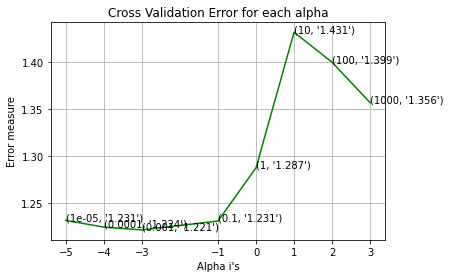

For values of best alpha =  0.001 The train log loss is: 0.811153692954889
For values of best alpha =  0.001 The cross validation log loss is: 1.2211114286262346
For values of best alpha =  0.001 The test log loss is: 1.2944941572659465


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>2. Testing the model with best hyper paramters</h4>

Log Loss : 1.3563965742542667
Number of missclassified point : 0.35714285714285715
-------------------- Confusion matrix --------------------


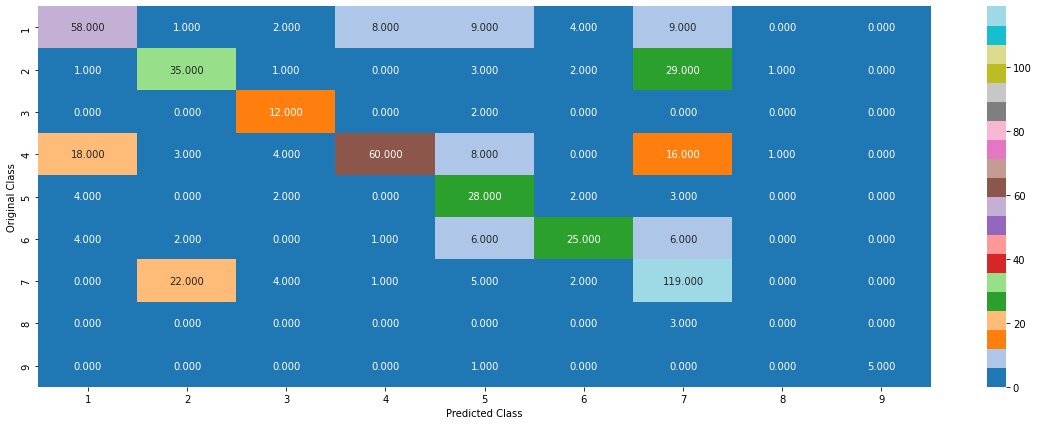

-------------------- Precision matrix (Columm Sum=1) --------------------


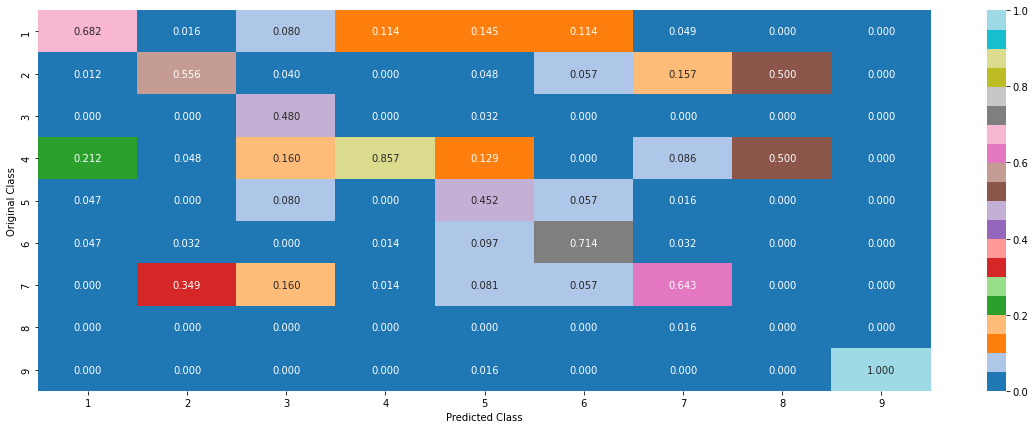

-------------------- Recall matrix (Row sum=1) --------------------


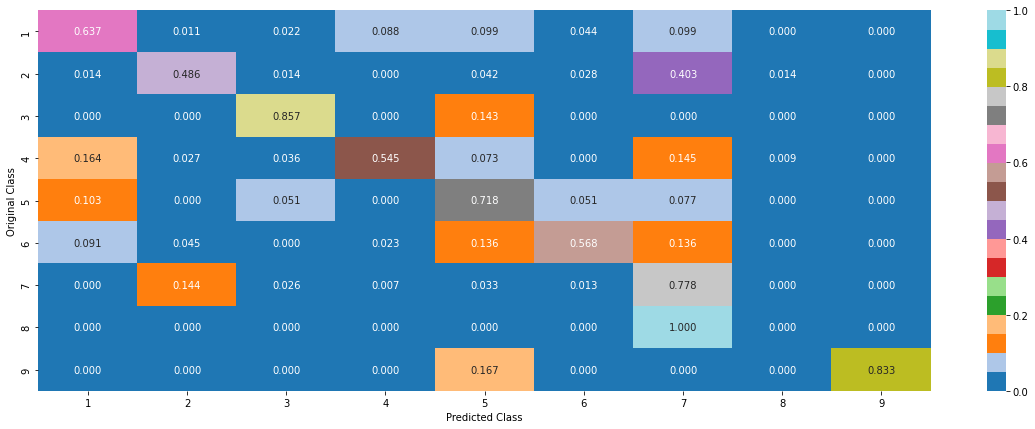

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_prob = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>3. Feature Importance, Correctly classified point</h4>

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0889 0.0806 0.0123 0.1051 0.0397 0.0319 0.6314 0.0051 0.005 ]]
Actual Class : 7
--------------------------------------------------
18 Text feature [presence] present in test data point [True]
19 Text feature [kinase] present in test data point [True]
20 Text feature [downstream] present in test data point [True]
21 Text feature [activating] present in test data point [True]
22 Text feature [independent] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
25 Text feature [well] present in test data point [True]
26 Text feature [recently] present in test data point [True]
27 Text feature [cell] present in test data point [True]
28 Text feature [factor] present in test data point [True]
29 Text feature [cells] present in test data point [True]
30 Text feature [growth] present in test data point [True]
31 Text feature [shown] present in test data point [True]
32 Text feature [activation] pres

In [ ]:
X_test['TEXT'].iloc[test_point_index]

'abstract adhesion tumor cells host cell layers subsequent migration pivotal steps cancer invasion metastasis small gtp binding protein rhoa controls cell adhesion motility organization actin cytoskeleton regulation actomyosin contractility cultured rat mm1 hepatoma cells migrate mesothelial cell monolayer vitro serum dependent rhoa mediated manner k yoshioka et al j biol chem 273 5146 5154 1998 furthermore rock family rhoa associated serine threonine protein kinases involved migration inhibitor kinases effectively inhibits invasion mm1 cells vitro vivo k itoh et al nat med 5 221 225 1999 although reports genetic alterations directly affecting rhoa human cancer expression level rhoa tumors several times higher surrounding normal tissue rhoa especially highly expressed metastatic region determine whether rhoa activated overexpression made stable transfectants mm1 cells expressing various levels wild type human rhoa transfectants showed promoted invasive ability vitro absence presence 1 

In [ ]:
no_feature

100

In [ ]:
X_test['Gene'].iloc[test_point_index]

'RHOA'

In [ ]:
X_test['Variation'].iloc[test_point_index]

'Amplification'

In [ ]:
clf.coef_.shape

(9, 54869)

In [ ]:
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
indices[0]

array([27434, 30544, 16207, 43789, 43800, 43802, 43804, 43762, 43824,
       43828, 43830, 43834, 43835, 16170, 16168, 16184, 43756, 43753,
       43750, 43707, 16263, 16262, 16259, 16258, 30543, 43724, 16246,
       43725, 43727, 43731, 16241, 43746, 16229, 43749, 30548, 43854,
       16162, 16161, 43977, 43978, 16097, 43981, 16094, 32739, 30551,
       43993, 43995, 16085, 43997, 43998, 44000, 44006, 44009, 43976,
       16266, 43960, 16113, 43856, 43858, 16157, 43861, 43864, 43867,
       43874, 43878, 43888, 16145, 32741, 16138, 16130, 43933, 16120,
       43959, 44010, 16267, 43701, 43560, 30523, 43563, 16384, 16383,
       43568, 16392, 16381, 16371, 16368, 30524, 43584, 16364, 43590,
       16380, 16394, 16395, 16397, 43496, 43507, 43511, 43512, 43517,
       43524])

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
for i in range(10):
  test_point_index = i
  no_feature = 100
  predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
  print("Predicted Class :", predicted_cls[0])
  print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
  print("Actual Class :", test_y[test_point_index])
  indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
  print("-"*50)
  get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index].lower(), X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 9
Predicted Class Probabilities: [[0.1775 0.0761 0.0115 0.0997 0.0374 0.03   0.1084 0.0048 0.4546]]
Actual Class : 9
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.0889 0.0806 0.0123 0.1051 0.0397 0.0319 0.6314 0.0051 0.005 ]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.0889 0.0806 0.0123 0.1051 0.0397 0.0319 0.6314 0.0051 0.005 ]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 2
Predicted Class Probabilities: [[0.0986 0.5522 0.0136 0.1166 0.0441 0.0353 0.1283 0.0057 0.0055]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class 

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 5
Predicted Class Probabilities: [[0.1175 0.1062 0.0159 0.1382 0.4149 0.042  0.152  0.0068 0.0065]]
Actual Class : 4
--------------------------------------------------
Out of the top  100  features  0 are present in query point


# K-Nearest Neighbour

<h4>1. Hyper parameter tuning</h4>

In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

print("**************************************************************************************")
# cv_log_error_array    

for alpha = 5
Log Loss : 1.052060170440399
for alpha = 11
Log Loss : 1.0315929925067397
for alpha = 15
Log Loss : 1.0392415433927056
for alpha = 21
Log Loss : 1.0603494030198
for alpha = 31
Log Loss : 1.0760157377103328
for alpha = 41
Log Loss : 1.0727203003112598
for alpha = 51
Log Loss : 1.094634141012656
for alpha = 99
Log Loss : 1.1397699010952893
**************************************************************************************


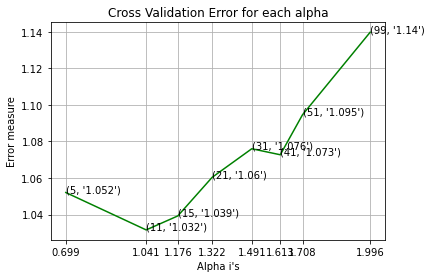

For values of best alpha =  11 The train log loss is: 0.5849881393268965
For values of best alpha =  11 The cross validation log loss is: 1.0315929925067397
For values of best alpha =  11 The test log loss is: 1.0870389845720767


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>2. Testing the model with best hyper paramters</h3>

Log-Loss:  1.0315929925067397
Number of mis-classified points : 0.34210526315789475
-------------------- Confusion matrix --------------------


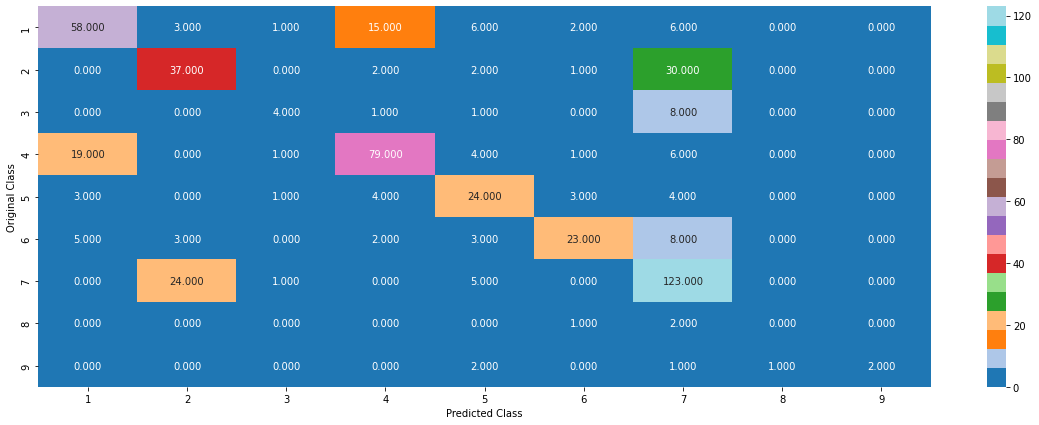

-------------------- Precision matrix (Columm Sum=1) --------------------


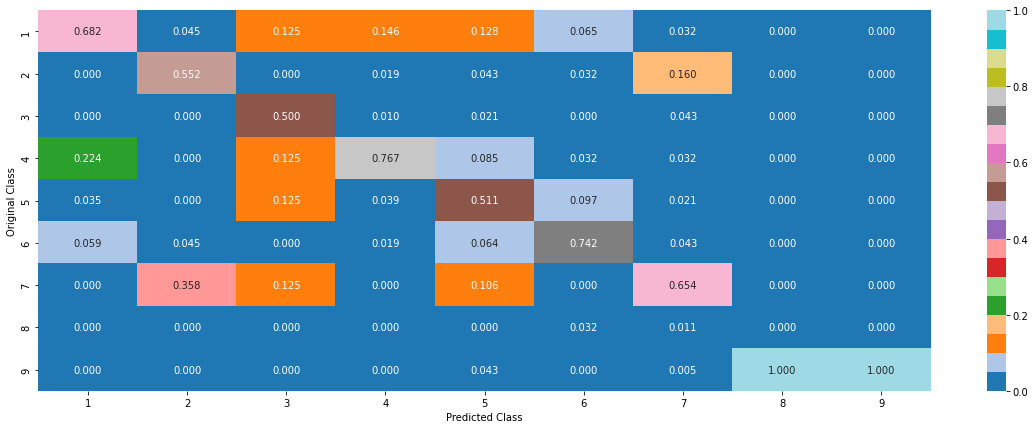

-------------------- Recall matrix (Row sum=1) --------------------


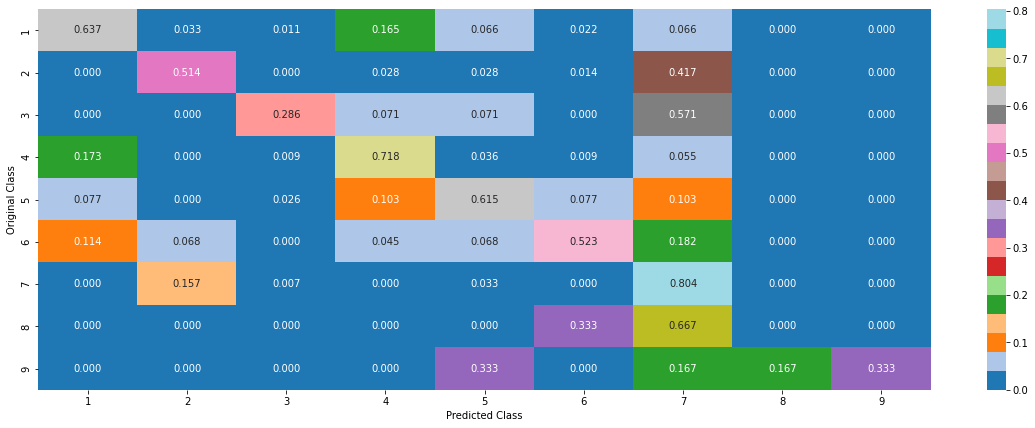

In [ ]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------

clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

<h3>3. Sample Query point -1</h3>

In [ ]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())

    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [2 2 7 7 7 2 7 2 7 7 2]
Fequency of nearest points : Counter({7: 6, 2: 5})


<h3>4. Sample Query point -2</h3>

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 4
The  11  nearest neighbours of the test points belongs to classes [4 4 6 4 4 4 5 1 4 1 4]
Fequency of nearest points : Counter({4: 7, 1: 2, 6: 1, 5: 1})


<h3>5. Sample Query point -3</h3>

In [ ]:
for i in range(10):
  test_point_index = i
  predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
  print("Predicted Class :", predicted_cls[0])
  print("Actual Class :", test_y[test_point_index])
  neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
  print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
  print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))
  print("-"*100)

Predicted Class : 4
Actual Class : 9
The  11  nearest neighbours of the test points belongs to classes [9 9 4 3 1 4 1 4 1 4 4]
Fequency of nearest points : Counter({4: 5, 1: 3, 9: 2, 3: 1})
----------------------------------------------------------------------------------------------------
Predicted Class : 4
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [2 2 7 7 7 2 7 2 7 7 2]
Fequency of nearest points : Counter({7: 6, 2: 5})
----------------------------------------------------------------------------------------------------
Predicted Class : 4
Actual Class : 7
The  11  nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 11})
----------------------------------------------------------------------------------------------------
Predicted Class : 4
Actual Class : 2
The  11  nearest neighbours of the test points belongs to classes [2 2 2 2 7 7 2 2 6 2 7]
Fequency of nearest points : 

<h2>3. Logistic Regression</h2>

<h3>3.1. With Class balancing</h3>

<h4>3.1.1. Hyper paramter tuning</h4>

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------

alpha = [10**x for x in range(-5,2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(loss='log', penalty='l2', alpha=i,class_weight="balanced")
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

print("**************************************************************************************")
# cv_log_error_array  

for alpha = 1e-05
Log Loss : 1.306877552920643
for alpha = 0.0001
Log Loss : 1.1549779413155075
for alpha = 0.001
Log Loss : 1.1125858232246992
for alpha = 0.01
Log Loss : 1.1582146407462723
for alpha = 0.1
Log Loss : 1.4825503737165013
for alpha = 1
Log Loss : 1.70556787196968
for alpha = 10
Log Loss : 1.7310460453740157
**************************************************************************************


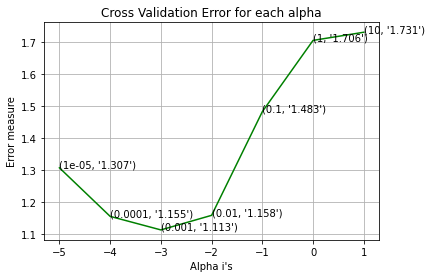

For values of best alpha =  0.001 The train log loss is: 0.5132458224134132
For values of best alpha =  0.001 The cross validation log loss is: 1.1152491703610874
For values of best alpha =  0.001 The test log loss is: 1.1405239489955912


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha[best_alpha], class_weight="balanced")
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>3.1.2. Testing the model with best hyper paramters</h4>

Log Loss : 1.7310460453740157
Number of missclassified point : 0.3533834586466165
-------------------- Confusion matrix --------------------


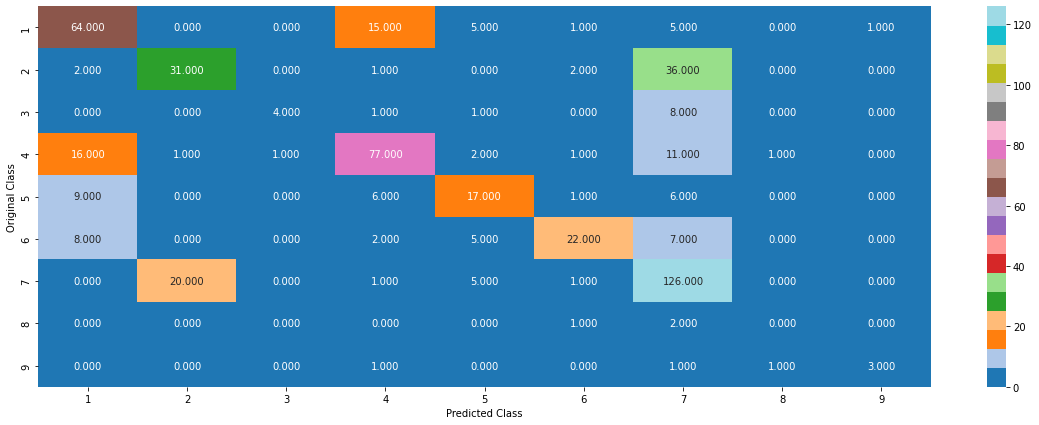

-------------------- Precision matrix (Columm Sum=1) --------------------


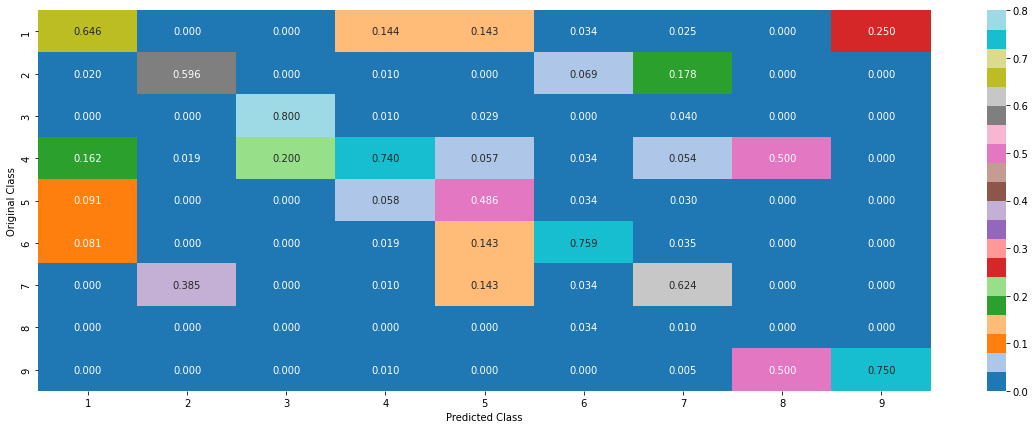

-------------------- Recall matrix (Row sum=1) --------------------


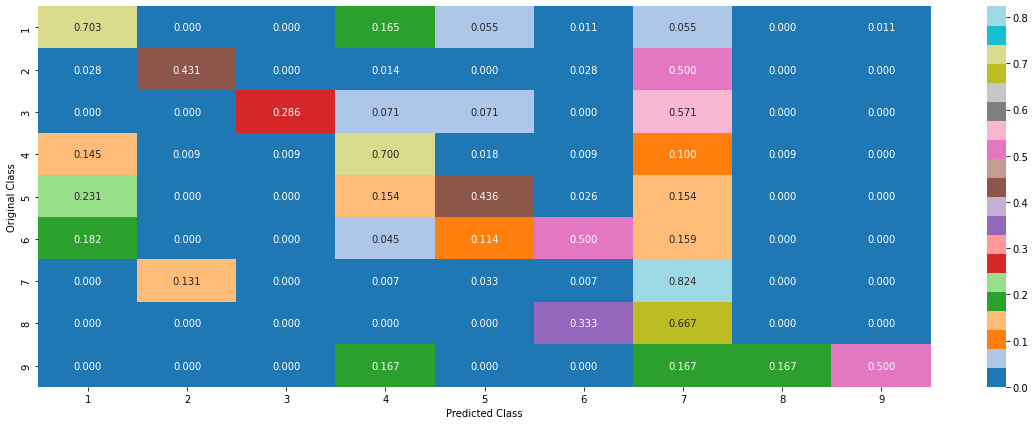

In [ ]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha[best_alpha], class_weight="balanced")
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_prob = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>3.1.3. Feature Importance</h4>

In [ ]:

def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_onehotencoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [ ]:
from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.600e-03 9.200e-03 6.000e-04 5.200e-03 5.000e-04 3.000e-04 9.799e-01
  1.700e-03 1.100e-03]]
Actual Class : 7
--------------------------------------------------
92 Text feature [constitutively] present in test data point [True]
95 Text feature [3t3] present in test data point [True]
107 Text feature [nude] present in test data point [True]
155 Text feature [affected] present in test data point [True]
161 Text feature [oncogene] present in test data point [True]
175 Text feature [activated] present in test data point [True]
197 Text feature [mitogen] present in test data point [True]
201 Text feature [grew] present in test data point [True]
215 Text feature [preimmune] present in test data point [True]
220 Text feature [rac] present in test data point [True]
250 Text feature [extracellular] present in test data point [True]
254 Text feature [loss] present in test data point [True]
256 Text feature [function] present in test data poin

<h5>3.1.3.1. Correctly Classified point</h5>

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0684 0.0191 0.0055 0.5561 0.247  0.0843 0.0097 0.004  0.0057]]
Actual Class : 4
--------------------------------------------------
261 Text feature [instability] present in test data point [True]
406 Text feature [382] present in test data point [True]
445 Text feature [mss] present in test data point [True]
454 Text feature [adapted] present in test data point [True]
479 Text feature [counseling] present in test data point [True]
Out of the top  500  features  5 are present in query point


<h5>3.1.3.2. Incorrectly Classified point</h5>

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.600e-03 9.200e-03 6.000e-04 5.200e-03 5.000e-04 3.000e-04 9.799e-01
  1.700e-03 1.100e-03]]
Actual Class : 7
--------------------------------------------------
30 Text feature [constitutively] present in test data point [True]
33 Text feature [3t3] present in test data point [True]
40 Text feature [nude] present in test data point [True]
71 Text feature [oncogene] present in test data point [True]
78 Text feature [activated] present in test data point [True]
92 Text feature [mitogen] present in test data point [True]
96 Text feature [grew] present in test data point [True]
Out of the top  100  features  7 are present in query point


<h3>3.2. Without Class balancing</h3>

<h4>3.2.1. Hyper paramter tuning</h4>

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------

alpha = [10**x for x in range(-5,2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(loss='log', penalty='l2', alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

print("**************************************************************************************")
# cv_log_error_array  

for alpha = 1e-05
Log Loss : 1.292302527446117
for alpha = 0.0001
Log Loss : 1.1466650733120283
for alpha = 0.001
Log Loss : 1.1327379803408477
for alpha = 0.01
Log Loss : 1.2119648139217154
for alpha = 0.1
Log Loss : 1.4590255549603228
for alpha = 1
Log Loss : 1.6448332488991741
for alpha = 10
Log Loss : 1.6775343423182099
**************************************************************************************


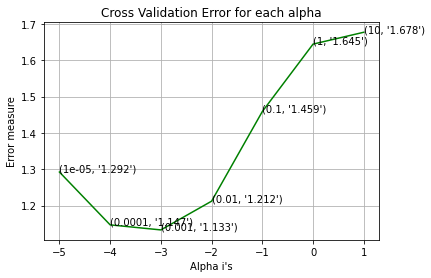

For values of best alpha =  0.001 The train log loss is: 0.5123294215762453
For values of best alpha =  0.001 The cross validation log loss is: 1.1303594336313516
For values of best alpha =  0.001 The test log loss is: 1.1509539962332223


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h4>3.2.2. Testing model with best hyper parameters</h4>

Log Loss : 1.6775343423182099
Number of missclassified point : 0.35150375939849626
-------------------- Confusion matrix --------------------


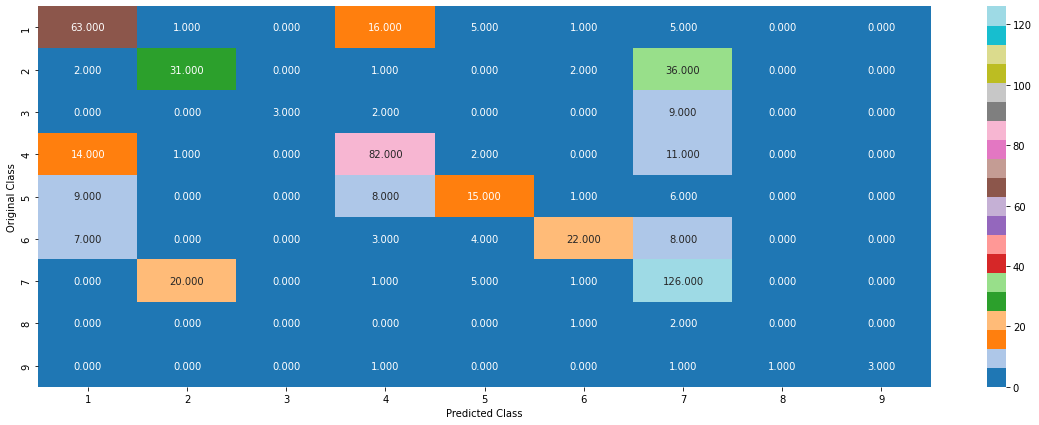

-------------------- Precision matrix (Columm Sum=1) --------------------


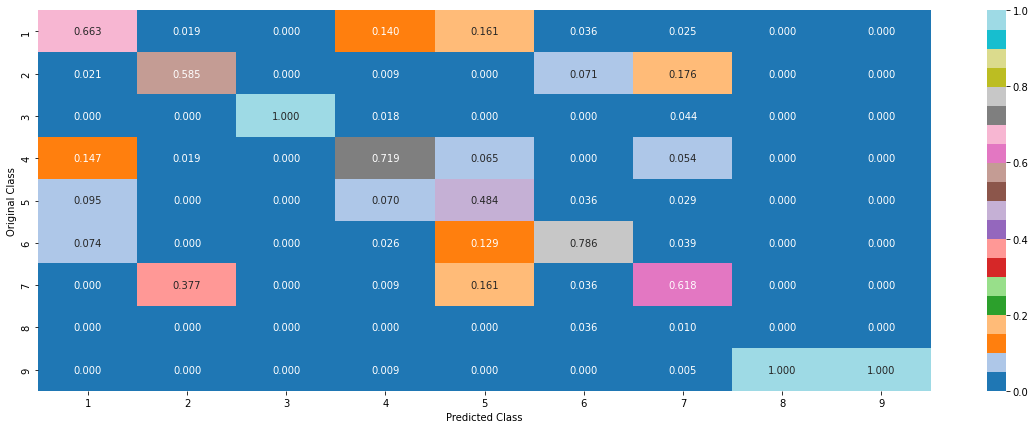

-------------------- Recall matrix (Row sum=1) --------------------


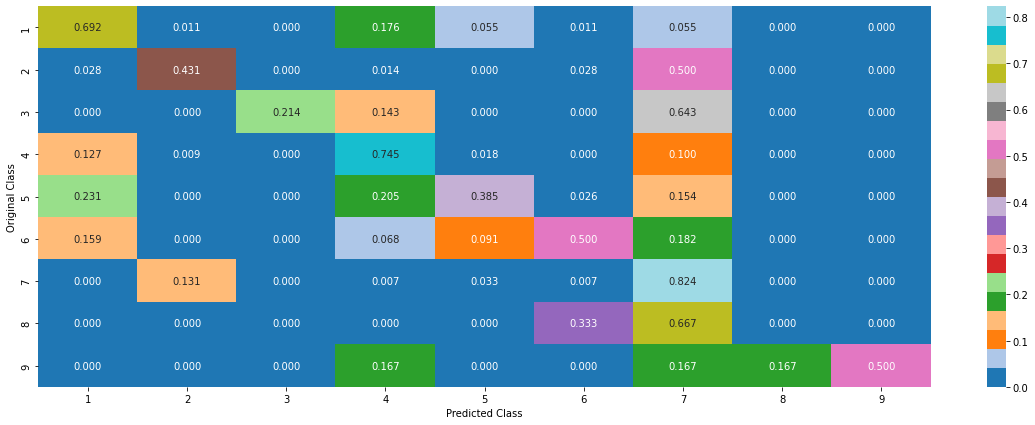

In [ ]:
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_prob = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

<h4>3.2.3. Feature Importance, Correctly Classified point</h4>

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_onehotencoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [ ]:
from tabulate import tabulate
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.700e-03 1.010e-02 4.000e-04 6.200e-03 4.000e-04 2.000e-04 9.761e-01
  3.000e-04 4.500e-03]]
Actual Class : 7
--------------------------------------------------
154 Text feature [3t3] present in test data point [True]
174 Text feature [constitutively] present in test data point [True]
214 Text feature [nude] present in test data point [True]
258 Text feature [rab] present in test data point [True]
297 Text feature [grew] present in test data point [True]
298 Text feature [activating] present in test data point [True]
308 Text feature [oncogene] present in test data point [True]
332 Text feature [activated] present in test data point [True]
349 Text feature [expressing] present in test data point [True]
350 Text feature [mitogen] present in test data point [True]
367 Text feature [extracellular] present in test data point [True]
416 Text feature [preimmune] present in test data point [True]
427 Text feature [6244] present in test dat

<h4>3.2.4. Feature Importance, Inorrectly Classified point</h4>

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.066  0.0188 0.0054 0.58   0.2341 0.076  0.012  0.0032 0.0045]]
Actual Class : 4
--------------------------------------------------
381 Text feature [instability] present in test data point [True]
449 Text feature [counseling] present in test data point [True]
471 Text feature [382] present in test data point [True]
492 Text feature [adapted] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index],X_test['Gene'].iloc[test_point_index],X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[1.700e-03 1.010e-02 4.000e-04 6.200e-03 4.000e-04 2.000e-04 9.761e-01
  3.000e-04 4.500e-03]]
Actual Class : 7
--------------------------------------------------
82 Text feature [3t3] present in test data point [True]
95 Text feature [constitutively] present in test data point [True]
Out of the top  100  features  2 are present in query point


# Linear Support Vector Machines

<h3>4.1. Hyper paramter tuning</h3>

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------

alpha = [10**x for x in range(-5,2)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(loss='hinge', penalty='l2', alpha=i, class_weight="balanced")
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

print("**************************************************************************************")
# cv_log_error_array  

for alpha = 1e-05
Log Loss : 1.3175445903322278
for alpha = 0.0001
Log Loss : 1.26619319707834
for alpha = 0.001
Log Loss : 1.1296433294684076
for alpha = 0.01
Log Loss : 1.1119065867485727
for alpha = 0.1
Log Loss : 1.3586643437247117
for alpha = 1
Log Loss : 1.7194154245449682
for alpha = 10
Log Loss : 1.734248533256343
**************************************************************************************


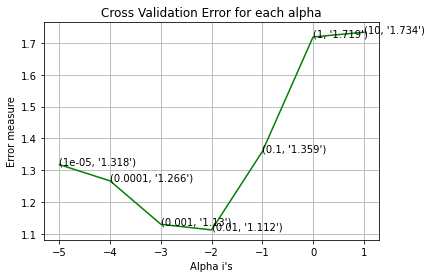

For values of best alpha =  0.01 The train log loss is: 0.7395853372798147
For values of best alpha =  0.01 The cross validation log loss is: 1.1559217853653307
For values of best alpha =  0.01 The test log loss is: 1.1828442176001728


In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha[best_alpha], class_weight="balanced")
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.734248533256343
Number of missclassified point : 0.35150375939849626
-------------------- Confusion matrix --------------------


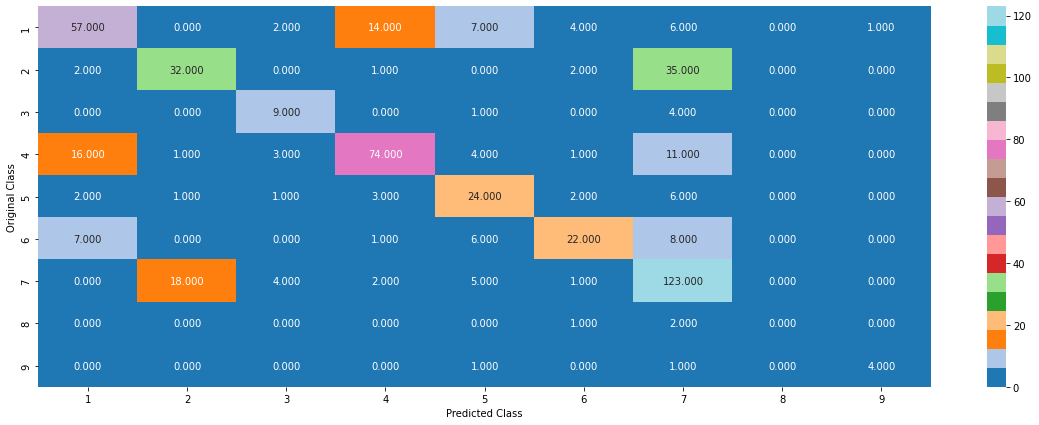

-------------------- Precision matrix (Columm Sum=1) --------------------


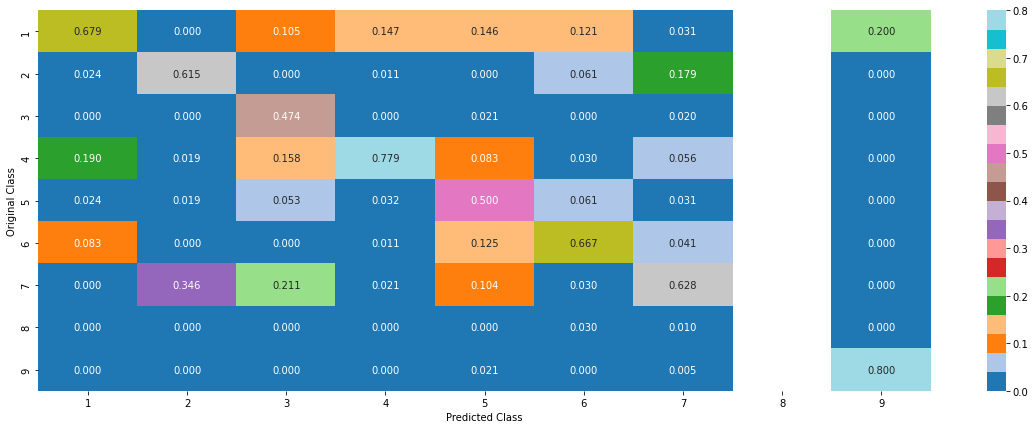

-------------------- Recall matrix (Row sum=1) --------------------


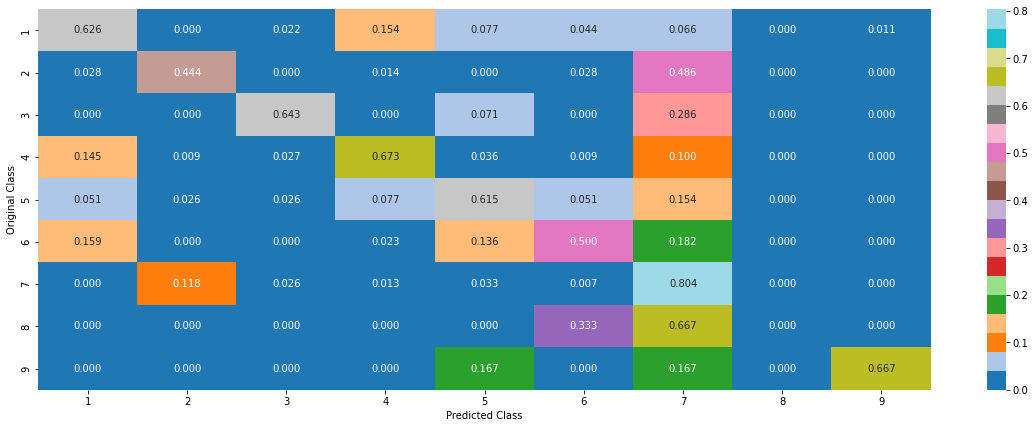

In [ ]:
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=alpha[best_alpha], class_weight="balanced")
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_prob = sig_clf.predict_proba(cv_x_onehotCoding)

# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

# 5 Random Forest Classifier

<h3>5.1. Hyper paramter tuning (With One hot Encoding)</h3>

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------


max_depth = [10,20]
alpha = [100,200,300,400,500,1000,2000]
cv_log_error_array = []
for i in alpha:
  for j in max_depth:
    print("for alpha(n_estimators) =", i,"and max_depth",j)
    clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=-1, random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha(n_estimators) = 100 and max_depth 10
Log Loss : 1.1913147857535635
for alpha(n_estimators) = 100 and max_depth 20
Log Loss : 1.2083484829883597
for alpha(n_estimators) = 200 and max_depth 10
Log Loss : 1.190091579541806
for alpha(n_estimators) = 200 and max_depth 20
Log Loss : 1.2080079279137266
for alpha(n_estimators) = 300 and max_depth 10
Log Loss : 1.1886635455276222
for alpha(n_estimators) = 300 and max_depth 20
Log Loss : 1.2033852895261956
for alpha(n_estimators) = 400 and max_depth 10
Log Loss : 1.1893283052054329
for alpha(n_estimators) = 400 and max_depth 20
Log Loss : 1.2042429649957918
for alpha(n_estimators) = 500 and max_depth 10
Log Loss : 1.188056862336161
for alpha(n_estimators) = 500 and max_depth 20
Log Loss : 1.203851569479967
for alpha(n_estimators) = 1000 and max_depth 10
Log Loss : 1.1865334241616132
for alpha(n_estimators) = 1000 and max_depth 20
Log Loss : 1.2024820928049589
for alpha(n_estimators) = 2000 and max_depth 10
Log Loss : 1.186983187923056


ValueError: ignored

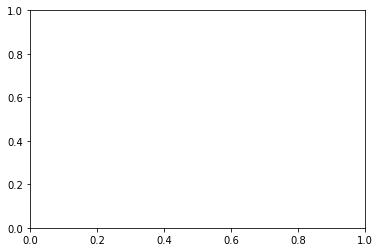

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=-1, random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h3>5.2. Testing model with best hyper parameters (One Hot Encoding)</h3>

In [ ]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------


max_depth = [10,20]
alpha = [100,200,300,400,500,1000,2000]
cv_log_error_array = []
for i in alpha:
  for j in max_depth:
    print("for alpha(n_estimators) =", i,"and max_depth",j)
    clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=-1, random_state=42)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, n_jobs=-1, random_state=42)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<h2>7 Stack the models </h2>

<h3>7.1 testing with hyper parameter tuning</h3>

In [ ]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------


# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------


clf1 = SGDClassifier(loss='hinge', penalty='l2', random_state=0, class_weight="balanced")
clf1.fit(train_x_onehotCoding,y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, train_y)

clf2 = SGDClassifier(loss='log', penalty='l2', random_state=0, class_weight="balanced")
clf2.fit(train_x_onehotCoding,y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")
sig_clf2.fit(train_x_onehotCoding, train_y)

clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

<h3>7.2 testing the model with the best hyper parameters</h3>

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

<h3>7.3 Maximum Voting classifier </h3>

In [ ]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))